# Process channels 1-4
Here the processing of channels 1 to 4 of Alsdorf is done.
The resulting data is analysed in the other notebooks.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from copy import deepcopy#, copy
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file

import plotly
import plotly.express as px
import kaleido

# reloads modules if something is changed in them <-- thats real magic :)
# I can adapt my functions and dont have to restart the notebook to load the new stuff
# be carefull with dependencies, when using from ... import ...
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year, import_tlogger
from my_func_mvw.functions import find_nearest_date, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, calc_stat_of_difference, carpet_plot_with_gaps, save_values_in_file, add_nan_val_in_datagaps
from my_func_mvw.additional_corrections import correct_lienar_trend 
from my_func_mvw.functions_dts_processing import watertank_shift, cut_dataframe_to_range_tlogger, check_processed_data, calc_mean_for_each_segment, plot_segments_mean_correction, const_shift_data, diff_to_watertank, check_first_last_date

############## Input ####################
plot_save=False #True False
masterthesis_save=False #True False
show_large_plot=False #True False
save_data=False #True False; only data with segments is saved
save_2019_processed_data=False # True False; save the data which is public
fast_calc=False #True False; shortens the data, dont use it with save_data=True
process_without_segments=False #True False; False is default

path_DTS_processed = r"..\Alsdorf\Daten\DTS_processed"
importer = "pickle" #csv pickle #does not work for tlogger at the moment
##########################################

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.3.4
pickle version: 4.0


In [2]:
# Load pickle Data
if importer == "pickle":
    data_all = read_pickle(path_DTS_processed + "\import_data_scripts\data_all")

# delete egrt cable channels
for egrt_chan in ["5","6","7","8"]:
    del data_all[egrt_chan]

In [3]:
# divide into segments of the same calibration (QuickStart)
# dates are from sciebo\DTS Data\Alsdorf\reports

string=["2019-02-15 12:50:44","2019-07-24 12:48:19","2019-12-19 10:10:44","2020-01-29 11:08:25","2020-03-13 17:04:59","2020-03-18 11:49:41",
    "2020-05-15 10:31:49","2020-12-09 11:02:45", "2021-04-07 12:43:35", "2021-04-26 10:57:11",
    "2021-04-28 09:41:06", "2021-05-20 16:02:01", "2021-06-01 15:06:12", "14-07-2021 14:16:59", "22-07-2021 13:30:29","2021-10-06 11:01:47"]
dates=[pd.to_datetime(s) for s in string] #also used later for plotting
first_date=data_all["1"].index[0] # first_date is before first string
last_date=data_all["4"].index[-1]

calibration_segments = []
first_segment=[first_date, dates[0]] # first_date is before first string
last_segment=[dates[-1],last_date]

calibration_segments.append(first_segment)
for i in range(0,len(dates[1:])): #skip first one because its first_segment
    segment = [dates[i], dates[i+1]]
    calibration_segments.append(segment)
calibration_segments.append(last_segment)

#used for calculating segment wise mean
#for all segments before water tank logger measurements I need to use the first segment
calibration_segments_in_logger_range=calibration_segments[13:]
dates_in_logger_range = dates[12:]

## Raw data

every 10th value plotted


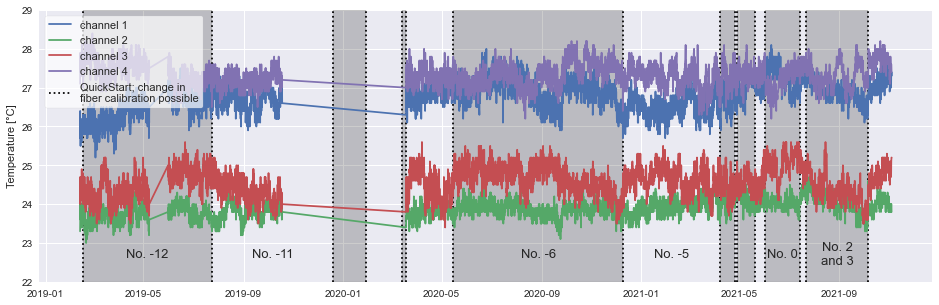

In [4]:
def plot_segments_overview(data, channels, length=500, from_date=0, ymin=22,ymax=29,x=10, show_segments=True,plot_mean=False,resampled_data="no need if plot_mean=False"):
    """x: plot every x value
    different segments needed, so this plot is not the same as in process_ch5-8.ipynb
    """
    def color_cable_pos_seg(calibration_segment, alph, axs, ymax=30, ymin=20, col="black", label_name="none", label=False): # Color correction Segments
        """ creates patches which color the plot
        I slightly adapt this for every notebook
        """
        start_len = calibration_segment[0].to_pydatetime()
        end_len = calibration_segment[1].to_pydatetime()
        width = end_len - start_len
        Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
        axs.add_patch(Rectangle)
        if label:
            #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
            bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
            date_num=(start_len+width/2)
            axs.text(date_num,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

    fig,axs=plt.subplots(1,1,figsize=(16,5))
    # Plot QuickStart positions
    axs.vlines(dates,ymin,ymax,colors="black",linestyle=":",label="QuickStart; change in \nfiber calibration possible")

    # Plot data
    for chan in channels:
        val=round(data[chan][length][from_date:][::x],1) #nur jeder x Wert
        axs.plot(val.index.to_pydatetime(),val.values,label=f"channel {chan}")
    
    if plot_mean:
        # mean off all channels
        summe=0
        # to avoid datagaps when a nan occurs; I think I need calculate this date wise.
        for chan in channels:
            summe += resampled_data[chan][length]
        mean=summe/4 #nan values should cause nan in mean too
        mean=mean[::x]
        axs.plot(mean.index.to_pydatetime(),mean.values,label=f"mean of all channels",color="black", linestyle="--")
        axs.fill_between(mean.index.to_pydatetime(),mean.values-1, mean.values+1,
                        #facecolor="blue", # The fill color
                        color='#7fc7ff',       # The outline color
                        alpha=0.3, label = "1 °C range around mean")          # Transparency of the fill

    # Assecoirs
    if show_segments:
        # Color plot
        # Ich muss anscheinend hier axs explicit einfügen
        alph=0.0
        counter=-13
        for segment in calibration_segments:
            if counter in [-12,-11,-6,-5,0,2,3]: #No.2 and No.3 are one segment here
                if_label=True
            else:
                if_label=False
            if counter==2:
                counter_print="2\nand 3"
            else:
                counter_print=counter
            color_cable_pos_seg(segment,alph,ymax=ymax,ymin=ymin,axs=axs, label_name=f"No. {counter_print}",label=if_label)
            if alph == 0.0:
                alph+=0.2
            elif alph == 0.2:
                alph=0.0
            if counter==2:
                counter+=2
            else:
                counter+=1

    #axs.set_xlabel("Date")
    axs.set_ylabel("Temperature [°C]")
    axs.set_ylim(ymin,ymax)
    legend = plt.legend(fontsize=11, title_fontsize=11,frameon=True,loc="upper left")
    legend.get_frame().set_facecolor("white")
    legend.get_frame().set_alpha(0.7) #not supported with eps
    print(f"every {x}th value plotted")

    return length

# Plot raw data
length=plot_segments_overview(data_all,channels=["1","2","3","4"])

if plot_save:
    plt.savefig(r"pictures\raw_data_ch14.png")
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\raw_data_ch14.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\raw_data_ch14.png", format="png",bbox_inches="tight",dpi=300)
        # Save additional information so I can read them in my tex file
        save_values_in_file(1,"cable_length_plot_raw_data_ch14",length,r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt")
plt.show()

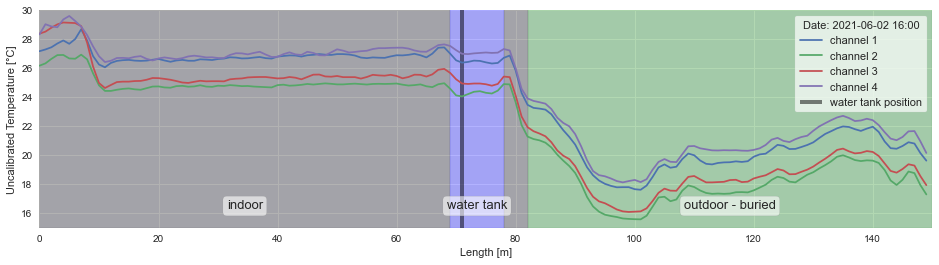

In [5]:
# Show the water tank positions at raw data

def color_cable_pos(start_len, end_len, alph, axs, ymax=30, ymin=20, col="black", label_name="none", label=False):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.6)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

iloc_date_index=59812 # change me
ymin=15;ymax=30

# Plot
fig,axs=plt.subplots(1,1,figsize=(16,4))
for chan in ["1","2","3","4"]:
    data_chan=data_all[chan].iloc[iloc_date_index][:150]
    axs.plot(data_chan,label=f"channel {chan}")

# Assecoirs
date_name=str(data_all["2"].iloc[iloc_date_index].name.round("1h"))[:-3]
axs.set_ylabel("Uncalibrated Temperature [°C]")
axs.set_xlabel("Length [m]")
axs.set_xlim(0,150)
axs.set_ylim(ymin,ymax)
axs.vlines([71],ymin,ymax,label="water tank position",color="black",linewidth=4,alpha=0.5)

color_cable_pos(0,69,0.3,ymax=ymax,ymin=ymin,axs=axs, label_name="indoor", label=True)
color_cable_pos(69,78,0.3,ymax=ymax,ymin=ymin,axs=axs,col="blue", label_name="water tank", label=True)
color_cable_pos(78,82,0.3,ymax=ymax,ymin=ymin,axs=axs,col="black")
color_cable_pos(82,150,0.3,ymax=ymax,ymin=ymin,axs=axs,col="green", label_name="outdoor - buried", label=True)

legend = axs.legend(fontsize=11, title_fontsize=11,frameon=True,title=f"Date: {date_name}",loc="upper right")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)

if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\watertank_loc_raw_ch14.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\watertank_loc_raw_ch14.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig("pictures\watertank_loc_raw_ch14.png")
plt.show()

In [6]:
# Import TLogger
df_Tlogger, df_Tlogger_PT1000 = import_tlogger(path_DTS_processed=path_DTS_processed,importer=importer)
watertank_T_range_min = df_Tlogger.index.min()
watertank_T_range_max = df_Tlogger.index.max()
df_Tlogger

,Channel1-Watertank,Channel2-Air,Channel1_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-10-06 10:49:47,17.7,NaN,17.7
2021-10-06 10:52:47,17.7,NaN,17.7
2021-10-06 10:55:47,17.7,NaN,17.7
2021-10-06 10:58:47,17.7,NaN,17.7


## Aligning

In [7]:
# 60s
data_all_processed=deepcopy(data_all)
a = data_all_processed
#delete some dates so all gaps are alligned
# do not change order of these, because this would change the indexes for the others

# allign first dates
a["1"] = a["1"].drop(a["1"].index[0],axis=0)

a["1"] = a["1"].drop(a["1"].index[274],axis=0)
a["2"] = a["2"].drop(a["2"].index[274],axis=0)
a["3"] = a["3"].drop(a["3"].index[274],axis=0)

a["1"] = a["1"].drop(a["1"].index[4263],axis=0)
a["2"] = a["2"].drop(a["2"].index[4263],axis=0)
a["4"] = a["4"].drop(a["4"].index[4263],axis=0)

a["1"] = a["1"].drop(a["1"].index[12485],axis=0)

a["1"] = a["1"].drop(a["1"].index[20211],axis=0)
a["2"] = a["2"].drop(a["2"].index[20211],axis=0)
a["3"] = a["3"].drop(a["3"].index[20211],axis=0)

# only measurements from 29.01.2020 are droped here, because they are not alligned
a["1"] = a["1"].drop(a["1"].index[20215 : 20217],axis=0)
a["2"] = a["2"].drop(a["2"].index[20215 : 20217],axis=0)
a["3"] = a["3"].drop(a["3"].index[20215 : 20218],axis=0)
a["4"] = a["4"].drop(a["4"].index[20215],axis=0)

a["1"] = a["1"].drop(a["1"].index[20217],axis=0)

a["1"] = a["1"].drop(a["1"].index[21171],axis=0)
a["2"] = a["2"].drop(a["2"].index[21171],axis=0)
a["3"] = a["3"].drop(a["3"].index[21171:21173],axis=0)
a["4"] = a["4"].drop(a["4"].index[21171],axis=0)

a["1"] = a["1"].drop(a["1"].index[40532],axis=0)
a["2"] = a["2"].drop(a["2"].index[40532],axis=0)
a["3"] = a["3"].drop(a["3"].index[40532],axis=0)
a["4"] = a["4"].drop(a["4"].index[40532],axis=0)

a["1"] = a["1"].drop(a["1"].index[44126],axis=0)
a["2"] = a["2"].drop(a["2"].index[44126],axis=0)
a["3"] = a["3"].drop(a["3"].index[44126],axis=0)
a["4"] = a["4"].drop(a["4"].index[44126],axis=0)

a["1"] = a["1"].drop(a["1"].index[53895],axis=0)

a["1"] = a["1"].drop(a["1"].index[54822],axis=0)

a["1"] = a["1"].drop(a["1"].index[56698],axis=0)
a["2"] = a["2"].drop(a["2"].index[56698],axis=0)

a["1"] = a["1"].drop(a["1"].index[56700],axis=0)

a["1"] = a["1"].drop(a["1"].index[58407],axis=0)
a["2"] = a["2"].drop(a["2"].index[58407],axis=0)

a["1"] = a["1"].drop(a["1"].index[58678:58681],axis=0)
a["2"] = a["2"].drop(a["2"].index[58678:58682],axis=0)
a["3"] = a["3"].drop(a["3"].index[58678:58680],axis=0)
a["4"] = a["4"].drop(a["4"].index[58678:58680],axis=0)

a["1"] = a["1"].drop(a["1"].index[59747],axis=0)

a["1"] = a["1"].drop(a["1"].index[62154],axis=0)
a["2"] = a["2"].drop(a["2"].index[62154],axis=0)
a["3"] = a["3"].drop(a["3"].index[62154],axis=0)

a["1"] = a["1"].drop(a["1"].index[20216],axis=0)
a["2"] = a["2"].drop(a["2"].index[20216],axis=0)
a["3"] = a["3"].drop(a["3"].index[20216],axis=0)
a["4"] = a["4"].drop(a["4"].index[20216],axis=0)

a["1"] = a["1"].drop(a["1"].index[64715],axis=0)


############needs to be adapted with every new import##################
a["1"] = a["1"].drop(a["1"].index[-1],axis=0)
a["2"] = a["2"].drop(a["2"].index[-1],axis=0)
a["3"] = a["3"].drop(a["3"].index[-1],axis=0)
#########################################################################

check_first_last_date(a,["1","2","3","4"])


Channel: 1; Number of dates: 66872
first (oldest) date: 2019-02-12 10:10:23
last (newest) date: 2021-11-04 09:41:17

Channel: 2; Number of dates: 66872
first (oldest) date: 2019-02-12 10:14:23
last (newest) date: 2021-11-04 09:45:17

Channel: 3; Number of dates: 66872
first (oldest) date: 2019-02-12 10:18:23
last (newest) date: 2021-11-04 09:49:17

Channel: 4; Number of dates: 66872
first (oldest) date: 2019-02-12 10:22:23
last (newest) date: 2021-11-04 09:53:18


In [8]:
data_all_processed_withoutTlogger = deepcopy(data_all_processed)
data_all_processed = cut_dataframe_to_range_tlogger(channels=["1","2","3","4"],data=data_all_processed,
                        watertank_T_range_min=watertank_T_range_min, watertank_T_range_max=watertank_T_range_max, do_check=False)

In [9]:
# Plot "unprocessed" temperatures
if show_large_plot:     
    carpet_plot_with_gaps(data_all_processed_withoutTlogger,["1","2","3","4"],title_prefix="",
                         vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\raw_data_ch14_carpet.png")
        if masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\watertank_loc_raw_ch14.pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\watertank_loc_raw_ch14.png", format="png",bbox_inches="tight",dpi=300)
    plt.show()

In [10]:
# Check processed data
print("Check data_all_processed:")
my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed)

print()
print("Check data_all_processed_withoutTlogger:")
my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed_withoutTlogger)

Check data_all_processed:
Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed

Check data_all_processed_withoutTlogger:
Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [11]:
if fast_calc:
    for chan in data_all_processed_withoutTlogger.keys(): #only use every 10s value at the moment to make calcukations faster
        data_all_processed_withoutTlogger[chan] = data_all_processed_withoutTlogger[chan][::10]

## Calculate offset and shift

In [12]:
# 70s
watertank_len=[71] # position DTS cable, where it is in watertank

# Correction for waterteank temp difference
data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger, channels=["1","2","3","4"], watertank_len=watertank_len,
                            watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Performance warning ist denke ich nicht so wichtig

### Process ch 1-4 with mean watertank shift
here I will process channel 1-4 with the mean watertank shift.
Therefore I will divide the data in different "QuickStart" sets.

In [13]:
if process_without_segments:
    calibration_nosegments_mean_correction_real_data={}
    for chan in ["1","2","3","4"]:
        calibration_nosegments_mean_correction_real_data[chan]=np.nanmean(watertank_diff_log_data_all[chan][watertank_len[0]])

if process_without_segments == False: # this means processing with segments (default)
    result = calc_mean_for_each_segment(["1","2","3","4"], calibration_segments_in_logger_range, watertank_diff_log_data_all, watertank_len)
    calibration_segments_mean_correction_real_data = result[0]
    # only for finding correspnding values in watertank_diff_log_data_all; not in data_all !!!
    calibration_segments_mean_correction_real_data_dates = result[1] 
    del result

    # Manual correction of segments
    correction_channels_seg_no4={"1":0.3,"2":0,"3":1,"4":0} # <----- change me if needed
    for chan in ["1","2","3","4"]:
        calibration_segments_mean_correction_real_data[chan][3]=calibration_segments_mean_correction_real_data[chan][2]+correction_channels_seg_no4[chan]
    display(calibration_segments_mean_correction_real_data)

c:\Users\Mathis\ownCloud\DTS Data\Scripts\my_func_mvw\functions_dts_processing.py:246: RuntimeWarning: Mean of empty slice
  segment_mean = np.nanmean(data[date_iloc_start+5:date_iloc_end-5])


{'1': [2.8562093862815887,
  2.8051315789473685,
  2.605631038647343,
  2.9056310386473427],
 '2': [-0.06502890173410392,
  0.16339207048458187,
  -0.006211892544521577,
  -0.006211892544521577],
 '3': [0.8965437454808388,
  0.5408333333333338,
  0.1931763285024155,
  1.1931763285024155],
 '4': [3.1516052060737527,
  3.5408733624454154,
  3.1451147342995167,
  3.1451147342995167]}

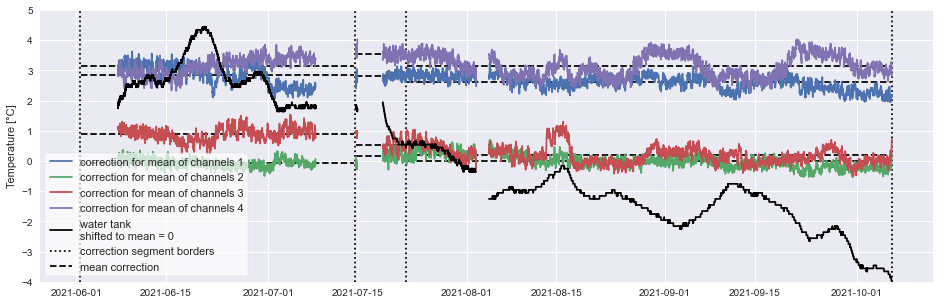

In [14]:
# Plot correction values over time
if process_without_segments == False:
    plot_segments_mean_correction(calibration_segments_mean_correction_real_data,dates_in_logger_range,calibration_segments_mean_correction_real_data_dates,
                    watertank_diff_log_data_all,df_Tlogger,watertank_len,ymax=5, ymin=-4)

    if plot_save:
        plt.savefig(r"pictures\analyse_watertank_correction_ch14.png",bbox_inches="tight")
        if masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap3\analyse_watertank_correction_ch14.pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap3\analyse_watertank_correction_ch14.png", format="png",bbox_inches="tight",dpi=300)
    plt.show()

In [15]:
if process_without_segments:
    ymax=5; ymin=-4
    start = pd.to_datetime("2021-06-01 19:00:00")
    end=watertank_diff_log_data_all["1"].index[-1]
    fig,axs=plt.subplots(1,1,figsize=(16,5))
    for chan in ["1","2","3","4"]:
        x=watertank_diff_log_data_all[chan].index
        y=watertank_diff_log_data_all[chan][watertank_len[0]]
        axs.plot(x,y,label=f"correction for channel {chan}")

        axs.hlines(calibration_nosegments_mean_correction_real_data[chan], start, end, color="black", linestyle="--", label="mean correction")

    # Plot watertank Temp for comparisson
    name="Channel1_rolling_mean"
    mean = np.nanmean(df_Tlogger[name].values)
    y=df_Tlogger[name].values - mean
    x_dates=df_Tlogger[name].index
    axs.plot(x_dates,y,color="black", label="water tank\nshifted to mean = 0")

    # Assecoirs
    axs.set_title("Analyse Water Tank Correction", fontsize=13)
    axs.set_xlabel("Date")
    axs.set_ylabel("Temperature [°C]")
    axs.set_ylim(ymin,ymax)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) # but them in dictionary: uniqueness, multiple labels are dropped
    # make legend looking nicer
    legend = axs.legend(by_label.values(), by_label.keys(),fontsize=11, title_fontsize=12,frameon=True) #loc="upper right"
    legend.get_frame().set_facecolor("white")
    legend.get_frame().set_alpha(0.7)

    if plot_save:
        plt.savefig(r"pictures\analyse_watertank_correction_ch14_nosegments.png",bbox_inches="tight")
        if masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap3\analyse_watertank_correction_ch14_nosegments.pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap3\analyse_watertank_correction_ch14_nosegments.png", format="png",bbox_inches="tight",dpi=300)
    plt.show()

In [16]:
# add shift value for segments, which can be calibrated from real data (segments before first water tank measurements)
if process_without_segments==False:
    calibration_segments_mean_correction_all_segments = {}
    n_segments = 13 # number of segments before the first segment with real data
    for chan in calibration_segments_mean_correction_real_data.keys():
        real_val_chan = calibration_segments_mean_correction_real_data[chan] #the segment correction values from the segments with real data
        all_segments_val_chan=[]
        for i in range(n_segments):
            all_segments_val_chan.append(real_val_chan[0]) # use first segment with real data for all segments before
        
        for i in range(len(real_val_chan)):
            all_segments_val_chan.append(real_val_chan[i]) # add segments with real data to new list
        
        calibration_segments_mean_correction_all_segments[chan] = all_segments_val_chan
    
    #display(calibration_segments_mean_correction_all_segments)

In [17]:
# Manual correction
# of the segments before the first water tank measurements

# at the moment these segments are not manually corected

In [18]:
# px.imshow(round(data_all["2"][::10],1),zmin=20,zmax=30)

# Correct data with const shift for each segment
Advantage: no datagaps (only the ones I want to have at segment borders).
At the moment the shift is determined with the data of the watertank correction for each sgement.
But especially for the older data of chan 1 to 4 I want to determine it from the raw data.
This should be also useful for the EGRT segment due to the large data gaps.

In [19]:
# if using fast_calc only every 10s value is used and saved!
if process_without_segments==False:
    data_all_processed_constshifted = const_shift_data(["1","2","3","4"], calibration_segments, calibration_segments_mean_correction_all_segments, data_all_processed_withoutTlogger,round_x=2)

if process_without_segments: # not the standrd calculation
    data_all_processed_constshifted={}
    # Correct data
    for chan in ["1","2","3","4"]:
        mean_correction = calibration_nosegments_mean_correction_real_data[chan]
        data_all_processed_constshifted[chan] = data_all_processed_withoutTlogger[chan] - mean_correction

## Additional corrections
only done for constshifted data

In [20]:
# Lienar trend correction
# the liner trend can be calculated for channels 5 to 8
# the minimum trend of these channels is used to correct the data of channels 1 to 4

linear_trend_correction={}
for chan in ["1","2","3","4"]:
    # value with lowest magnitue of channels 5 to 8
    # channel 7 only shaft water in analyse_my_database_alsdorf.ipynb: -0.00013320639375415715
    linear_trend_correction[chan]=-0.00013320639375415715 # [K/m]
data_all_processed_constshifted_additiocorr=correct_lienar_trend(data_all_processed_constshifted,linear_trend_correction)

del data_all_processed_constshifted # to make sure it is not used in one of the later cells

# Influence of linear trend about 0.1 K:
# diff=data_all_processed_constshifted["1"] - data_all_processed_constshifted_additiocorr["1"]
# col=diff.columns[700:800]
# diff[col]

In [21]:
# Add nan values in data gaps so they are plotted better,
# resample the data to make the dataset smaller

resampled_data={} # Used later in plot
sample_hours=1 #need to play around with it until all chanells have same index length after resample
for chan in ["1","2","3","4"]:
    # skip first row so all dataframes start at 14:xx:xx --> resampled to same dates
    # skip last so all end at same hour; NEEDS TO BE ADAPTED WITH NEW DATA
    data_with_nan = add_nan_val_in_datagaps(data_all_processed_constshifted_additiocorr[chan][1:-1], minutes_gap=35)
    resampled_data[chan]=data_with_nan.resample(f"{sample_hours}H").ffill()

print("Index Length:")
for chan in ["1","2","3","4"]:
    print(f"{chan}: {len(resampled_data[chan].index)}")
    print(f"first date: {resampled_data[chan].index[0]}; last date: {resampled_data[chan].index[-1]}")
    
# Original data, before adding nan
# print("Index Length:")
# for chan in ["5","6","7","8"]:
#    print(f"{chan}: {len(data_all_processed_constshifted_additiocorr[chan].index)}")
#    print(f"first date: {data_all_processed_constshifted_additiocorr[chan].index[1]};
#          last date: first date: {data_all_processed_constshifted_additiocorr[chan].index[-1]}")

7234 dates with nan have been added
7234 dates with nan have been added
7234 dates with nan have been added
7234 dates with nan have been added
Index Length:
1: 23904
first date: 2019-02-12 10:00:00; last date: 2021-11-04 09:00:00
2: 23904
first date: 2019-02-12 10:00:00; last date: 2021-11-04 09:00:00
3: 23904
first date: 2019-02-12 10:00:00; last date: 2021-11-04 09:00:00
4: 23904
first date: 2019-02-12 10:00:00; last date: 2021-11-04 09:00:00


every 10th value plotted


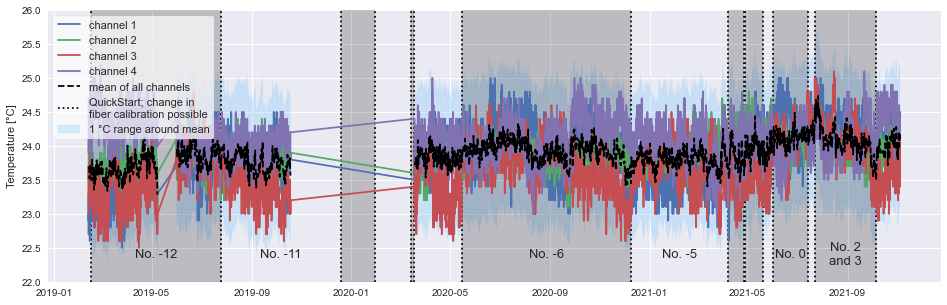

In [22]:
# Plot shifted data
show_segments=True
if process_without_segments:
    show_segments=False

cable_length=plot_segments_overview(data_all_processed_constshifted_additiocorr, channels=["1","2","3","4"], length=500, from_date=0, ymin=22,ymax=26,x=10,
                                show_segments=show_segments,plot_mean=True,resampled_data=resampled_data)

if masterthesis_save:# Save additional information so I can read them in my tex file
    save_values_in_file(2,"cable_length_plot_final_data_ch14_one_length",cable_length,r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt")

if process_without_segments==False:
    if plot_save:
        if masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\final_data_ch14_one_length.pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\final_data_ch14_one_length.png", format="png",bbox_inches="tight",dpi=300)
        plt.savefig(r".\pictures\final_data_ch14_one_length.png",bbox_inches="tight")
if process_without_segments:
    if plot_save:
        if masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\final_data_ch14_one_length_nosegments.pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\final_data_ch14_one_length_nosegments.png", format="png",bbox_inches="tight",dpi=300)
        plt.savefig(r".\pictures\final_data_ch14_one_length_nosegments.png",bbox_inches="tight")
plt.show()

# Extract Shaft

In [23]:
begin_shaft=200
complete_shaft_length = 860 #dieser Wert beschreibt wie weit die Faser von Channel 1 und 3 geht, bevor sie wieder nach oben geht

shaft={}
for chan in ["1","2","3","4"]:
    if chan in ["2","4"]: #shorter channels
        col = data_all_processed_constshifted_additiocorr[chan].columns[begin_shaft:]
    if chan in ["1","3"]: #longer channels
        col = data_all_processed_constshifted_additiocorr[chan].columns[begin_shaft:begin_shaft + complete_shaft_length]
    shaft[chan] = data_all_processed_constshifted_additiocorr[chan][col]
    shaft[chan].columns = np.arange(0,shaft[chan].columns.max() + 1 - begin_shaft)
    shaft[chan].columns.names=["Depth [m]"]
    shaft[chan] = round(shaft[chan],1)

In [24]:
# 2019 public data
# date ranges
public_data_date_begin="2019-02-12 10:00:00" #not used
public_data_date_end="2019-06-30 23:59:00" #dayfirst=True

# extrract heating phase 2019
date_name_end,date_iloc_end = find_nearest_date(public_data_date_end,shaft["1"].index)
shaft_public_2019={}
for chan in ["1","2","3","4"]:
    shaft_public_2019[chan]=shaft[chan].iloc[:date_iloc_end]

# check
my_Warning = check_processed_data(["1","2","3","4"],shaft_public_2019)

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


## Save data

In [25]:
if save_data and process_without_segments==False:
    # Save final Temperature Shaft
    save_to=path_DTS_processed + r"\shaft_temperatures\old_cable\pickle"
    for chan in ["1","2","3","4"]:
        filename=f"\\Schacht_chan_{chan}"
        write_pickle(save_to+filename,shaft[chan])

    save_to=path_DTS_processed + r"\shaft_temperatures\old_cable\csv"
    for chan in ["1","2","3","4"]:
        filename=f"\\Schacht_chan_{chan}"
        shaft[chan].to_csv(save_to+filename+".csv")
        
    # Save complete data
    write_pickle(path_DTS_processed + "\import_data_scripts\data_ch1-4_processed_constshifted",data_all_processed_constshifted_additiocorr)


In [26]:
# 2019 public data
if save_data and save_2019_processed_data:
    save_path=path_DTS_processed + "\\public_data_2019"
    for chan in ["1","2","3","4"]:
        filename=f"\\shaft_dts_processed_ch{chan}.csv"
        shaft_public_2019[chan].to_csv(save_path + filename)

In [27]:
# Carpet plot of final data
if show_large_plot:
    carpet_plot_with_gaps(data_all_processed_constshifted_additiocorr,["1","2","3","4"],title_prefix="",
                          vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\final_data_ch14_carpet.png")
        if masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\final_data_ch14_carpet.pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\final_data_ch14_carpet.png", format="png",bbox_inches="tight",dpi=300)
    plt.show()